In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
from multiprocessing import Pool

from scipy import stats

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-decam-dr9.fits.gz'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-90prime-dr9.fits.gz'
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9m/survey-ccds-mosaic-dr9.fits.gz'

# image_path_list = glob.glob(os.path.join(image_dir, '*ooi*.fits.fz'))
ccd = Table(fitsio.read(surveyccd_path))

In [4]:
mask = ccd['ccd_cuts']==0
ccd = ccd[mask]

In [5]:
# Only keep unique exposures
_, idx = np.unique(ccd['expnum'], return_index=True)
ccd = ccd[idx]

In [7]:
ccdnum_list = [1, 2, 3, 4]
ccd_ra = [0.2813, 0.2813, -0.2813, -0.2813]
ccd_dec = [0.263, -0.263, 0.263, -0.263]

binsize = 4
pix_size = 0.454/3600*binsize
vrange = 1.

22220 g 79240048


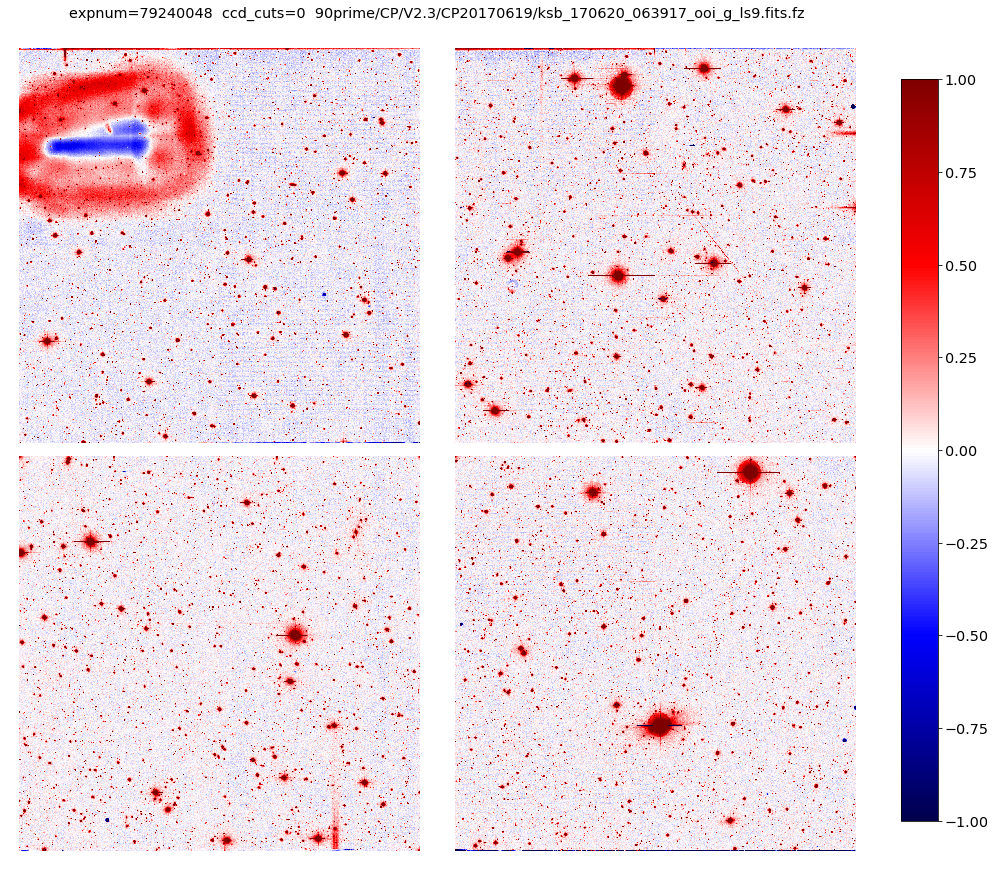

In [11]:
ccd_index = np.where(ccd['expnum']==79240048)[0][0]

expnum = ccd['expnum'][ccd_index]
band = ccd['filter'][ccd_index]
print(ccd_index, band, expnum)
fn = ccd['image_filename'][ccd_index]

plt.figure(figsize=(14, 14))

for ii, ccdnum in enumerate(ccdnum_list):
    
    try:
        img = fits.getdata('/global/cfs/cdirs/cosmo/staging/'+fn, extname='CCD'+str(ccdnum))
    except:
        print('Failure loading {}'.format('/global/cfs/cdirs/cosmo/staging/'+fn))
        continue
       
    # naive sky estimation
    mask = (img<np.percentile(img.flatten(), 95))
    median_sky = np.median(img[mask].flatten())
    img = img - median_sky

    ################ downsize image ################

    trim_size_x = img.shape[1] % binsize
    trim_size_y = img.shape[0] % binsize
    img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
    # to ignore NAN values, use np.nanmean
    img = np.nanmean(np.nanmean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

    ################################################

    ysize, xsize = img.shape        
    ra, dec = ccd_ra[ii], ccd_dec[ii]
    
    img[~np.isfinite(img)] = 0
    # img = gaussian_filter(img, 4, mode='reflect', truncate=3)
    fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
               extent=(ra+ysize*pix_size/2, ra-ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

plt.axis([0.55, -0.55, -0.55, 0.55])
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.colorbar(fraction=0.04, pad=0.04)
plt.title('expnum={}  ccd_cuts={}  {}'.format(expnum, ccd['ccd_cuts'][ccd_index], fn))
plt.tight_layout()
plt.show()

In [9]:
idx = np.where(ccd['expnum']==79240048)[0][0]

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('plots2/test.pdf') as pdf:

    for ccd_index in range(idx-2, idx+4):

        # from matplotlib.backends.backend_pdf import PdfPages
        # with PdfPages('plots/90prime_images-ccd4.pdf') as pdf:
        # for ccd_index in range(idx-20, idx+20):

        expnum = ccd['expnum'][ccd_index]
        band = ccd['filter'][ccd_index]
        print(ccd_index, band, expnum)
        fn = ccd['image_filename'][ccd_index]

        plt.figure(figsize=(14, 12))

        for ii, ccdnum in enumerate(ccdnum_list):

            try:
                img = fits.getdata('/global/cfs/cdirs/cosmo/staging/'+fn, extname='CCD'+str(ccdnum))
            except:
                print('Failure loading {}'.format('/global/cfs/cdirs/cosmo/staging/'+fn))
                continue

            # naive sky estimation
            mask = (img<np.percentile(img.flatten(), 95))
            median_sky = np.median(img[mask].flatten())
            img = img - median_sky

            ################ downsize image ################

            trim_size_x = img.shape[1] % binsize
            trim_size_y = img.shape[0] % binsize
            img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
            # to ignore NAN values, use np.nanmean
            img = np.nanmean(np.nanmean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

            ################################################

            ysize, xsize = img.shape        
            ra, dec = ccd_ra[ii], ccd_dec[ii]

            img[~np.isfinite(img)] = 0
            # img = gaussian_filter(img, 4, mode='reflect', truncate=3)
            fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                       extent=(ra+ysize*pix_size/2, ra-ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

        plt.axis([0.55, -0.55, -0.55, 0.55])
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.colorbar(fraction=0.04, pad=0.04)
        plt.title('expnum={}  ccd_cuts={}  {}'.format(expnum, ccd['ccd_cuts'][ccd_index], fn))
        plt.tight_layout()
        # plt.savefig(os.path.join(plot_dir, os.path.basename(image_path).replace('.fits.fz', '.png')))
        pdf.savefig()
        plt.close()

22218 r 79230154
22219 g 79240047
22220 g 79240048
22221 g 79240049
22222 g 79240050
22223 r 79240057
